# 16. 플럭스 사용법

In [1]:
versioninfo()

Julia Version 1.9.2
Commit e4ee485e909 (2023-07-05 09:39 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin22.4.0)
  CPU: 8 × Apple M2
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, apple-m1)
  Threads: 2 on 4 virtual cores


In [2]:
import MLDatasets

In [3]:
import Flux

In [4]:
import NNlib

In [5]:
import Flux: onehotbatch 

In [6]:
import MLUtils: DataLoader

In [7]:
# import CUDA: has_cuda

In [8]:
import Zygote

In [9]:
import Optimisers

In [10]:
import Formatting: printfmtln

In [11]:
using Random: MersenneTwister

In [12]:
import Plots

In [13]:
using DataFrames

In [14]:
using CSV

In [15]:
ENV["DATADEPS_ALWAYS_ACCEPT"] = true # 필요 데이터 자동 다운로드

true

## 16.1 데이터 준비

In [16]:
function get_data(batchsize = 64)
    xtrain, ytrain = MLDatasets.FashionMNIST(:train)[:]
    xtest, ytest = MLDatasets.FashionMNIST(:test)[:]

    xtrain = reshape(xtrain, 28, 28, 1, :)
    xtest = reshape(xtest, 28, 28, 1, :)

    ytrain, ytest = onehotbatch(ytrain, 0:9), onehotbatch(ytest, 0:9)

    train_loader = DataLoader((xtrain, ytrain), batchsize = batchsize)
    test_loader = DataLoader((xtest, ytest), batchsize = batchsize)

    return train_loader, test_loader
end

get_data (generic function with 2 methods)

### GPU setting

In [17]:
# CUDA는 cuDNN 설치가 되어 있지 않아 사용이 어려움

using CUDA

CUDA.functional()

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt ~/.julia/packages/Flux/u7QSl/ext/FluxCUDAExt/FluxCUDAExt.jl:56


false

In [18]:
# Mac M2 chip의 gpu를 사용할 수 있는 Metal.jl 패키지 이용 !

using Metal

# Flux.gpu_backend!("Metal")
# Flux.GPU_BACKEND

In [19]:
Metal.versioninfo()

macOS 13.5.0, Darwin 22.6.0

Toolchain:
- Julia: 1.9.2
- LLVM: 14.0.6

Julia packages: 
- Metal.jl: 0.5.1
- Metal_LLVM_Tools_jll: 0.5.1+0

1 device:
- Apple M2 (64.000 KiB allocated)


In [20]:
Metal.functional()

true

In [21]:
# Metal 패키지 사용 예제 실행

using Test

a = MtlArray{Int}(undef, 1024)

# essential memory operations, like copying, filling, reshaping, ...
b = copy(a)
fill!(b, 0)
@test b == Metal.zeros(Int, 1024)

# automatic memory management
a = nothing

In [22]:
a = Metal.zeros(1024)
b = Metal.ones(1024)
a.^2 .+ sin.(b)

1024-element MtlVector{Float32, Metal.MTL.MTLResourceStorageModePrivate}:
 0.841471
 0.841471
 0.841471
 0.841471
 0.841471
 0.841471
 0.841471
 0.841471
 0.841471
 0.841471
 0.841471
 0.841471
 0.841471
 ⋮
 0.841471
 0.841471
 0.841471
 0.841471
 0.841471
 0.841471
 0.841471
 0.841471
 0.841471
 0.841471
 0.841471
 0.841471

## 16.2 모델 생성

다음 함수가 리턴하는 모델은 (28, 28, 1, 배치 사이즈) 형상의 데이터를 (28*28, 배치 사이즈) 형상으로 평탄화한 후 완전 연결된(fully connected) 계층인 Dense로 연결한다.

In [23]:
function build_mlp_model(rng)
    Flux.Chain(
        Flux.flatten,
        Flux.Dense(28 * 28 => 512 , NNlib.relu; init = init(rng)),
        Flux.Dense(512 => 512, NNlib.relu; init = init(rng)),
        Flux.Dense(512 => 10 ; init = init(rng)),
    )
end

build_mlp_model (generic function with 1 method)

In [24]:
init(rng) = Flux.glorot_uniform(rng)

init (generic function with 1 method)

## 16.3 학습 및 테스트

### 모델 학습 함수

In [25]:
function train(loader, model, loss_fn, optimizer)
    num_batches = length(loader)
    losses = Float32[]
    Flux.testmode!(model, false)
    for (batch, (X, y)) in enumerate(loader)
        X, y = Flux.gpu(X), Flux.gpu(y)
        grad = Zygote.gradient(m -> loss_fn(m, X, y), model)[1]
        optimizer, model = Optimisers.update(optimizer, model, grad)
        if batch % 100 == 0
            loss = loss_fn(model, X, y)
            printfmtln("[Train] loss: {:.7f} [{:>3d}/{:>3d}]",
                loss, batch, num_batches)
            push!(losses, loss)
        end
    end
    model, optimizer, losses
end

train (generic function with 1 method)

### 모델 테스트 함수

In [26]:
function test(loader, model, loss_fn)
    num_batches = length(loader)
    Flux.testmode!(model, true)
    acc, tot = 0, 0
    loss = 0f0
    for (X, y) in loader
        X, y = Flux.gpu(X), Flux.gpu(y)
        pred = model(X)
        acc += sum(Flux.onecold(pred) .== Flux.onecold(y))
        tot += size(X)[end]
        loss += loss_fn(model, X, y)
    end
    acc, avg_loss = acc / tot * 100, loss / num_batches
    printfmtln("[Test] Accuracy: {:.1f}, Avg loss: {:.7f}", acc, avg_loss)
    acc, avg_loss
end

test (generic function with 1 method)

## 16.4 전체 실행

지금까지 작성한 함수들을 이용하여 다음과 같이 학습 및 테스트를 진행

In [27]:
rng = MersenneTwister(1);

In [28]:
model = build_mlp_model(rng) |> Flux.gpu
# Flux.Chain(
#    Flux.flatten,
#    Flux.Dense(784 => 512, NNlib.relu),
#    Flux.Dense(512 => 512, NNlib.relu),
#    Flux.Dense(512 => 10),
#)

Chain(
  Flux.flatten,
  Dense(784 => 512, relu),              # 401_920 parameters
  Dense(512 => 512, relu),              # 262_656 parameters
  Dense(512 => 10),                     # 5_130 parameters
)                   # Total: 6 arrays, 669_706 parameters, 648 bytes.

### 손실 함수 및 옵티마이저 지정

손실함수 loss_fn은 모델 m과 입력 변수 x, 종속변수 y를 받아서 손실을 계산하는 익명 함수

In [29]:
loss_fn = (m, x, y) -> Flux.Losses.logitcrossentropy(m(x), y);

옵티마이저 생성: Optimisers.setup 함수에 최적화 로직과 모델을 넘겨서 생성

In [30]:
optimizer = Optimisers.setup(Optimisers.Descent(0.001f0), model)

(layers = ((), (weight = Leaf(Descent(0.001), nothing), bias = Leaf(Descent(0.001), nothing), σ = ()), (weight = Leaf(Descent(0.001), nothing), bias = Leaf(Descent(0.001), nothing), σ = ()), (weight = Leaf(Descent(0.001), nothing), bias = Leaf(Descent(0.001), nothing), σ = ())),)

### 에폭별 실행

매 에폭마다 모델을 학습하고 손실 및 정확도를 구하기 위해 다음과 같은 함수를 작성

In [31]:
function run_epochs(loaders, model, loss_fn, optimizer, epochs)
    train_loader, test_loader = loaders
    train_losses, accuracies = [], [];
    for t in 1:epochs
        println("Epochs $t")
        println("---------------------------")
        model, optimizer, losses =
            train(train_loader, model, loss_fn, optimizer)
        train_losses = vcat(train_losses, losses)
        acc, _ = test(test_loader, model, loss_fn)
        push!(accuracies, acc)
    end
    model, train_losses, accuracies
end

run_epochs (generic function with 1 method)

* 위 함수의 반복문 안을 보면 train 함수가 반환한 모델과 옵티마이저를 다시 train 함수에 넘기는 것을 볼 수 있다. 이렇게 해야 이전 에폭에서 학습된 결과를 바탕으로 지속해서 학습이 이루어진다.

* 5 에폭으로 모델을 학습하고 테스트해 보자.

In [32]:
@time begin
    # 속도 측정 동시 진행 
    model, losses, accu = run_epochs(get_data(), model, loss_fn, optimizer, 5)
end

Epochs 1
---------------------------
[Train] loss: 2.1345654 [100/938]
[Train] loss: 1.9843962 [200/938]
[Train] loss: 1.7919340 [300/938]
[Train] loss: 1.7712075 [400/938]
[Train] loss: 1.6081743 [500/938]
[Train] loss: 1.5283515 [600/938]
[Train] loss: 1.4786059 [700/938]
[Train] loss: 1.4618603 [800/938]
[Train] loss: 1.2697319 [900/938]
[Test] Accuracy: 66.0, Avg loss: 1.2534889
Epochs 2
---------------------------
[Train] loss: 1.1759088 [100/938]
[Train] loss: 1.1838040 [200/938]
[Train] loss: 1.0162983 [300/938]
[Train] loss: 1.2045548 [400/938]
[Train] loss: 0.9553254 [500/938]
[Train] loss: 1.0074713 [600/938]
[Train] loss: 1.0611012 [700/938]
[Train] loss: 1.0963845 [800/938]
[Train] loss: 0.9053070 [900/938]
[Test] Accuracy: 71.3, Avg loss: 0.9295450
Epochs 3
---------------------------
[Train] loss: 0.8986330 [100/938]
[Train] loss: 0.9666424 [200/938]
[Train] loss: 0.7546752 [300/938]
[Train] loss: 1.0306990 [400/938]
[Train] loss: 0.7309981 [500/938]
[Train] loss: 0.82430

(Chain(flatten, Dense(784 => 512, relu), Dense(512 => 512, relu), Dense(512 => 10)), Any[2.1345654f0, 1.9843962f0, 1.791934f0, 1.7712075f0, 1.6081743f0, 1.5283515f0, 1.4786059f0, 1.4618603f0, 1.2697319f0, 1.1759088f0  …  0.68200207f0, 0.7302548f0, 0.82736766f0, 0.57011557f0, 0.90253747f0, 0.5522979f0, 0.67148894f0, 0.8020688f0, 0.81665826f0, 0.62921286f0], Any[65.95, 71.31, 74.4, 76.1, 77.29])

### 학습과정 손실 및 정확도 시각화

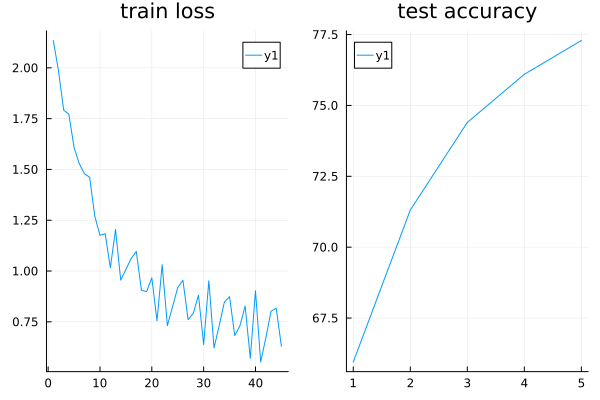

In [33]:
p1 = Plots.plot(losses, title = "train loss")
p2 = Plots.plot(accu, title = "test accuracy")
Plots.plot(p1, p2)

### 모델 저장 및 로딩

모델은 일반적인 줄리아 복합 타입이기 때문에, 어떠한 줄리아 객체 저장 형식을 사용해도 되지만 BSON.jl 패키지를 이용하는 BSON(Binary JSON) 포맷을 가장 많이 사용하는 편이다.

In [34]:
using BSON: @save

@save "mnist_mlp.bson" m = Flux.cpu(model)

**(코드 설명)** 

- 위 코드는 모델을 CPU로 보낸 후 m 이라는 키값으로 bson 파일에 저장함
- 모델이 GPU 장치에 있는 상태에서 저장할 경우, GPU를 지원하지 않는 컴퓨터에서는 모델 로딩이 실패할 수 있음

In [35]:
# 모델 로딩

using BSON: @load
import Flux, NNlib
@load "mnist_mlp.bson" m

bson 파일의 m 키값으로 저장된 모델을 불러온다. 이때 플럭스와 NNlib 패키지가 임포트되어 있어야 에러 없이 로딩이 된다. 
앞서 정의했던 get_data 함수를 이용하여 로딩된 모델을 테스트해보면 다음과 같음

In [39]:
import MLDatasets
using Flux: onehotbatch
using MLUtils: DataLoader

# function get_data(batchsize = 64) ~~ 
_, test_loader = get_data();
(X, y) = first(test_loader);
Flux.onecold(m(X)).-1, Flux.onecold(y).-1

([9, 2, 1, 1, 6, 1, 4, 4, 7, 7  …  4, 2, 8, 4, 8, 0, 7, 7, 8, 5], [9, 2, 1, 1, 6, 1, 4, 6, 5, 7  …  2, 2, 8, 4, 8, 0, 7, 7, 8, 5])

마지막 명령의 결과를 보면, 모델의 예측 결과인 m(X)가 타깃 y와 대체로 일치하여 학습된 모델이 잘 저장되고 로딩되었음을 알 수 있음

|패키지 | 역할 |
|:-----:|:---------:|
Flux.jl | 다양한 신경망 계층 타입 및 손실 함수 제공|
NNlib.jl | 활성화 함수, 합성곱 함수 등 신경망 구현에 필요한 함수 제공(플럭스에서 내부적으로 사용)
Zygote.jl | 자동 미분으로 모델 파라미터에 대한 손실의 기울기 계산
Optimisers.jl | ADAM 등 최적화 로직 및 모델 업데이트 함수 제공
Functors.jl  | 모델 파라미터에 함수 적용을 가능하게 함
MLUtils.jl  | 데이터 로더 등 파이프라인 관련 기능 제공
MLDatasets.jl | 데이터 셋 제공

독립된 패키지들이 각 기능을 담당하기 때문에 필요에 따라 특정 기능은 유사한 기능을 제공하는 다른 패키지를 사용할 수도 있음

- 예를 들어 신경망 계층 타입은 Flux.jl 대신 Lux.jl를 사용한다거나, 자동 미분을 소스 코드 변환 방식의 Zygote.jl 대신 트레이싱 방식의 Yota.jl을 사용하는 식이다.